In [3]:
import torch
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [69]:
# a concave function with one minimum
def f(x, a=0.0, b=0.1):
    if isinstance(x, torch.Tensor):
        return torch.log((x-a)**2 + b)
    else:
        return np.log((x-a)**2 + b)

def df(x, a=0.0, b=0.1):
    '''
    for 2d x
    '''
    numer = 2*(x-a)
    denom = (x-a)**2 + b
    return numer/denom

def hf(x, a=0.0, b=0.1):
    numer = 2*(b-(x-a)**2)
    denom = ((x-a)**2 + b)**2
    return numer/denom

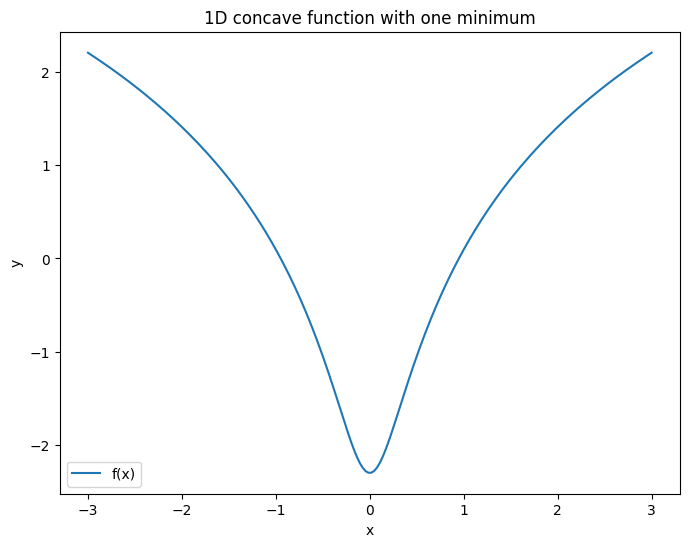

In [78]:
def draw_traj(ax, x_list=None):
    grid_size = 200
    x = np.linspace(-3, 3, grid_size)
    y = f(x)
    ax.plot(x, y, label='f(x)')
    if x_list is not None:
        y_list = f(np.array(x_list))
        # ax.scatter(x_list, y_list, label='trajectory')
        line1, = ax.plot(x_list, y_list, color='black', label='CG Trajectory')
        ax.scatter(x_list, y_list)
        ax.scatter(x_list[0], y_list[0], color='red', zorder=6, label='Start')
        ax.scatter(x_list[-1], y_list[-1], color='green', zorder=5, label='End')
    
    ax.set_title('1D concave function with one minimum')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    # ax.set_xlim(-3, 3)
    # ax.set_ylim(-3, 3)
    ax.legend()


fig, ax = plt.subplots(figsize=(8, 6))
draw_traj(ax)
plt.show()


#### 1D Newton

In [71]:
def newton(f, x0, max_iter, diff, hess, rate, tol=1e-5):
    
    lr = rate
    x_list = []
    x = x0.unsqueeze(0)
    x_copy = x0.clone().squeeze().detach().numpy()
    x_list.append(x_copy)
    
    for i in range(max_iter):
        
        deriv = diff(x).T
        hessian = hess(x)
        # print(deriv, hessian)
        dir = deriv/hessian
        dir = dir if deriv*dir > 0 else -dir
        x = x - lr*dir.T # for 1d inverse is just reciprocal
        x_copy = x.clone().squeeze().detach().numpy()
        if np.isnan(x_copy) or np.isinf(x_copy):
            print("out of bound at ", i , "th iteration: ", x_list[-1])
            break
        x_list.append(x_copy)
        if len(x_list) >= 2:
            if np.sum(np.sqrt((x_list[-1] - x_list[-2])**2)) < tol:
                print("converged at: ", i)
                break
        
    return x, np.array(x_list)

    

In [91]:
x = torch.tensor([-3.0]).requires_grad_(True)
max_iter = 5000
x, x_list = newton(f, x, max_iter, df, hf, rate = 0.5, tol=1e-5) 
print(x)

converged at:  15
tensor([[-8.8017e-06]], grad_fn=<SubBackward0>)


tensor([[-8.8017e-06]], grad_fn=<SubBackward0>)


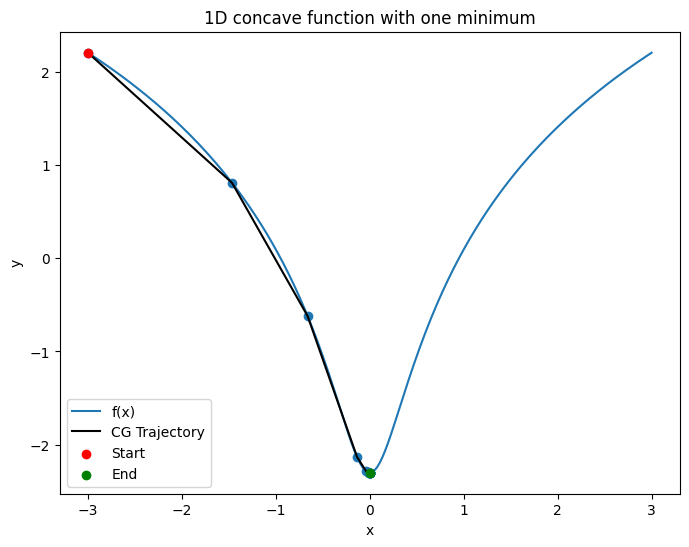

In [92]:
fig, ax = plt.subplots(figsize=(8, 6))
draw_traj(ax, x_list=x_list)
print(x)
plt.show()


#### Adam

In [67]:
def adam(f, x0, **f_args):
    hparams = f_args['opt_args']
    optim = torch.optim.Adam([x0], lr=hparams['learning_rate'])
    x_list = []
    x_copy = x0.clone().squeeze().detach().numpy()
    x_list.append(x_copy)
    for j in range(hparams['epochs']):
        # print(x_list)
        optim.zero_grad()

        loss = f(x0.unsqueeze(0))
        loss.backward()

        optim.step()
        x_copy = x0.clone().squeeze().detach().numpy()
        x_list.append(x_copy)
    
    return np.array(x_list)

In [97]:
hparams = {'epochs': 1500,
           'tol': 1e-6, # tolerance for CG
           'learning_rate': 0.1,
           'NR_max_iter': 200, # max iter for NR line search in CG
           'NR_tol': 1e-4, # tolerance for NR line search in CG
           'recompute': 2, # recompute the exact residual every n iterations
           }
x = torch.tensor([-3.0]).requires_grad_(True)
gd_list = adam(f, x, opt_args=hparams)

-1.1182688e-34
(1501,)


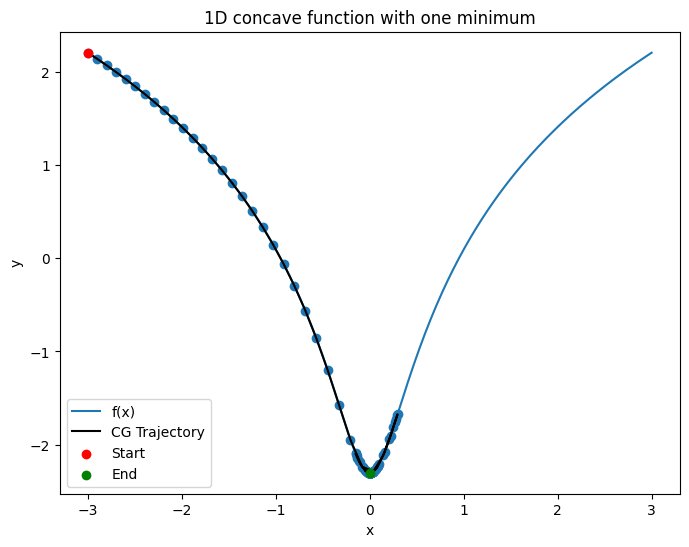

In [98]:
fig, ax = plt.subplots(figsize=(8, 6))
draw_traj(ax, x_list=gd_list)
print(gd_list[-1])
print(gd_list.shape)
plt.show()